# Semi-implicit Euler

It is possible to obtain symplectic semi-implicit Euler method considering approximation
$$\text{e}^{i\widetilde{L}\Delta t} = \text{e}^{iL_1\Delta t}\text{e}^{iL_2\Delta t}$$

As it was done for velocity-Verlet method
$$\begin{pmatrix}r(\Delta t) \\ p(\Delta t)\end{pmatrix} = \underbrace{\text{e}^{iL_1\Delta t}\underbrace{\text{e}^{iL_2\Delta t} \begin{pmatrix}r_0 \\ p_0\end{pmatrix}}_{1}}_{2} $$

1. $$\text{e}^{iL_2\Delta t} \begin{pmatrix}r_0 \\ p_0\end{pmatrix} = \text{e}^{F(r_0)\Delta t \frac{\partial}{\partial p}} \begin{pmatrix}r_0 \\ p_0\end{pmatrix} \\ =  \begin{pmatrix}r_0 \\ p_0 + F(r_0)\Delta t\end{pmatrix}$$
2. $$\text{e}^{iL_1\Delta t} \begin{pmatrix}r_0 \\ p_0 + F(r_0)\Delta t\end{pmatrix} = \text{e}^{\frac{p_0}{m}\Delta t \frac{\partial}{\partial r}} \begin{pmatrix}r_0 \\ p_0 + F(r_0)\Delta t\end{pmatrix} \\ = \begin{pmatrix}r_0 + \frac{p_0}{m}\Delta t\\ p_0 + F\left(r_0 + \frac{p_0}{m}\Delta t\right)\Delta t\end{pmatrix} = \begin{pmatrix}r(\Delta t) \\ p(\Delta t)\end{pmatrix}$$

One step of the method has a form
$$\begin{cases}r_{i+1} = r_i + v_i\Delta t \\ v_{i+1} = v_i + \frac{F(r_{i+1})}{m}\Delta t\end{cases}$$

To obtain some results we choose harmonic oscillator Hamiltonian
$$H = \frac{mv^2}{2} + \frac{m \omega^2 r^2}{2}$$
For the sake of simplicity, $m=1$, $\omega=1$
$$H = \frac{v^2}{2} + \frac{r^2}{2}$$

The force
$$F(r) = -\frac{\partial H}{\partial r} = - r$$

Let the initial condition be $r(0) = 1$ and $v(0)=0$. 
Then the initial energy is equal to $E_0 = \dfrac{v(0)^2}{2} + \dfrac{r(0)^2}{2} = 0.5$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def euler(x: np.ndarray, dt: float) -> np.ndarray:
    """Semi-implicit Euler method step

    Args:
        x (np.ndarray): current state. x[0] is r, x[1] is v
        dt (float): time step

    Returns:
        np.ndarray: new state
    """
    new_x = np.zeros_like(x)
    
    new_x[0] = x[0] + x[1] * dt
    new_x[1] = x[1] + (-new_x[0]) * dt
    
    return new_x

In [3]:
def compute_trajectory(x0: np.ndarray, dt: float, N: int, method_func: callable) -> np.ndarray:
    """Compute states for N steps with a specific method

    Args:
        x0 (np.ndarray): initial state
        dt (float): time step
        N (int): number of steps
        method_func (callable): method function

    Returns:
        np.ndarray: array of system's states
    """
    # new array for results
    xs = np.zeros((N, 2))
    # initial condition
    xs[0] = x0
    
    # iterating steps
    for n in range(N-1):
        xs[n+1] = method_func(xs[n], dt)
        
    return xs

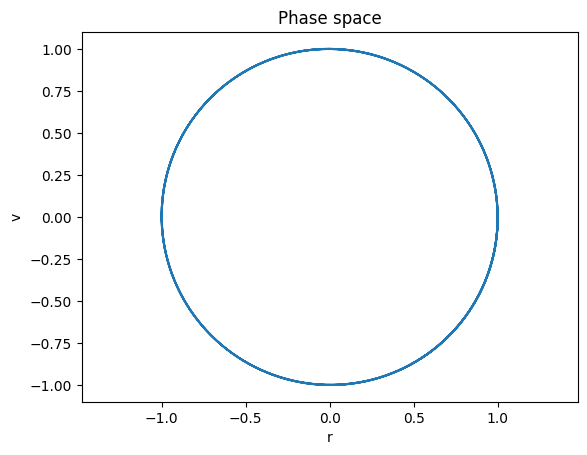

In [69]:
dt = 0.01
N = 2000
x0 = np.array([1., 0.])


xs = compute_trajectory(x0, dt, N, euler)
plt.plot(xs[:, 0], xs[:, 1])
plt.title("Phase space")
plt.xlabel("r")
plt.ylabel("v")
plt.axis('equal')
plt.show()

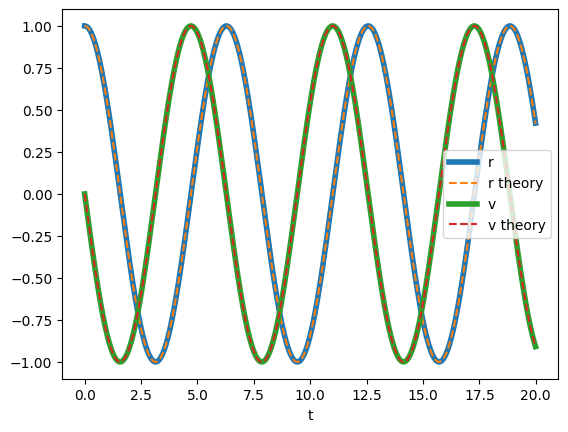

In [70]:
ts = np.linspace(0., N*dt, N, endpoint=False)
plt.plot(ts, xs[:, 0], label="r", linewidth=4)
plt.plot(ts, np.cos(ts), '--', label="r theory")
plt.plot(ts, xs[:, 1], label="v", linewidth=4)
plt.plot(ts, -np.sin(ts), '--', label="v theory")
plt.xlabel("t")
plt.legend()
plt.show()

The obtained solutions agree with those predicted by the theory.
Let's check whether the total energy is conserved

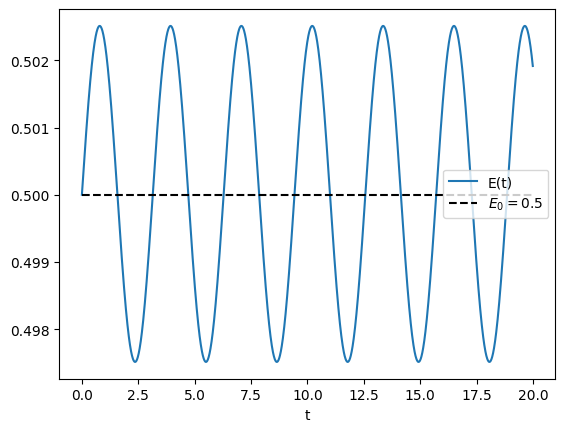

In [71]:
Es = xs[:,0]**2/2 + xs[:,1]**2/2
E0 = Es[0]
plt.plot(ts, xs[:,0]**2/2 + xs[:,1]**2/2, label=r"E(t)")
plt.hlines(E0, xmin=min(ts), xmax=max(ts), linestyle='--', color='black', label=r'$E_0 = 0.5$')
plt.legend()
plt.xlabel("t")
plt.show()

The total energy is not conserved, but oscillate around the initial energy.

Is there any connection between amplitude of energy oscillations $\max|E(t) - E_0|$ and time step $\Delta t$?

In [72]:
def energy_error(x0: np.ndarray, dt: float, N: int, method_func: callable) -> float:
    xs = compute_trajectory(x0, dt, N, method_func)
    Es = xs[:,0]**2/2 + xs[:,1]**2/2
    E0 = Es[0]
    return np.max(np.abs(E0 - Es))

In [73]:
dts = np.logspace(-4, 0, 30)
errors_euler = []
for _dt in dts:
    errors_euler.append(
        energy_error(x0=x0, dt=_dt, N=10000, method_func=euler)
    )

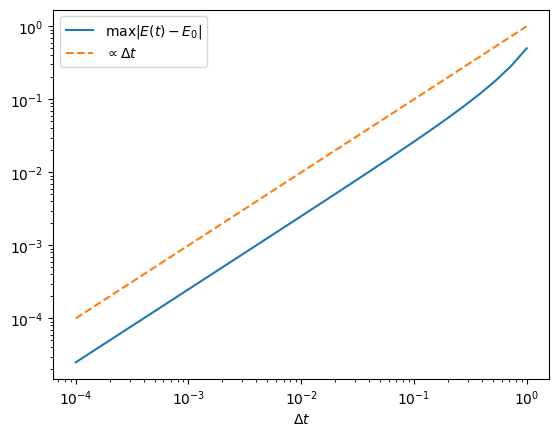

In [82]:
plt.loglog(dts, errors_euler, label="$\max|E(t) - E_0|$")
plt.plot(dts, dts, "--", label=r"$\propto \Delta t$")
plt.xlabel("$\Delta t$")
plt.legend()
plt.show()

As you can see, the energy drift proportional to $\Delta t$.
This is a consequence of the fact that the method is a first order integrator and $\widetilde{H}=H + O(\Delta t)$ (see the lecture).

Let's compare Semi-implicit Euler method with velocity-Verlet method.

# Velocity-Verlet

One-step formulas for velocity-Verlet method are
$$\begin{cases}r_{i+1} = r_i + v_i\Delta t + \frac{F(r_i)}{m}\frac{\Delta t ^2}{2} \\ v_{i+1} = v_i + \frac{\Delta t}{2}\left(\frac{F(r_i)}{m} + \frac{F(r_{i+1})}{m}\right)\end{cases}$$

In [75]:
def verlet(x: np.ndarray, dt: float) -> np.ndarray:
    """Velocity-Verlet method step

    Args:
        x (np.ndarray): current state. x[0] is r, x[1] is v
        dt (float): time step

    Returns:
        np.ndarray: new state
    """
    new_x = np.zeros_like(x)
    
    new_x[0] = x[0] + x[1] * dt + (-x[0]) * dt**2/2
    new_x[1] = x[1] + dt/2 * ((-x[0]) + (-new_x[0]))
    
    return new_x

In [76]:
xs = compute_trajectory(x0, dt, N, verlet)

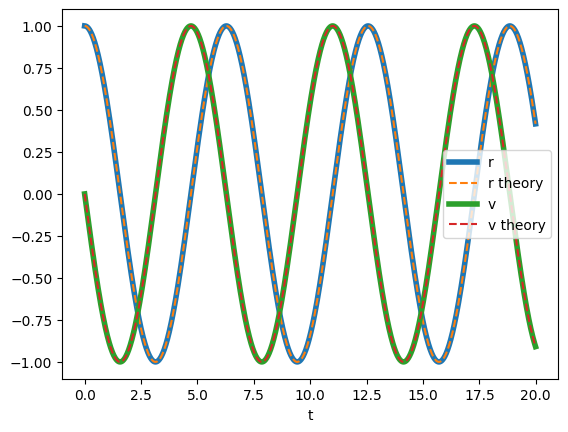

In [77]:
ts = np.linspace(0., N*dt, N, endpoint=False)
plt.plot(ts, xs[:, 0], label="r", linewidth=4)
plt.plot(ts, np.cos(ts), '--', label="r theory")
plt.plot(ts, xs[:, 1], label="v", linewidth=4)
plt.plot(ts, -np.sin(ts), '--', label="v theory")
plt.xlabel("t")
plt.legend()
plt.show()

In [80]:
dts = np.logspace(-4, 0, 30)
errors_verlet = []
for dt_ in dts:
    errors_verlet.append(
        energy_error(x0=x0, dt=dt_, N=10000, method_func=verlet)
    )

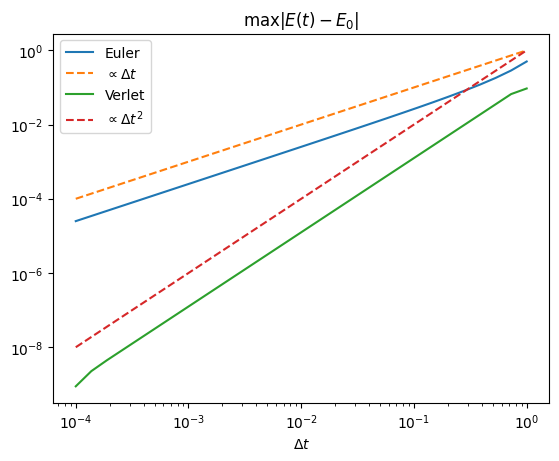

In [90]:
plt.loglog(dts, errors_euler, label="Euler")
plt.plot(dts, dts, "--", label=r"$\propto \Delta t$")

plt.loglog(dts, errors_verlet, label="Verlet")
plt.plot(dts, dts**2, "--", label=r"$\propto \Delta t^2$")

plt.title("$\max|E(t) - E_0|$")
plt.xlabel("$\Delta t$")
plt.legend()
plt.show()

Velocity-Verlet method is second-order method and $\widetilde{H}=H + O(\Delta t^2)$. 
As a result, the error in total energy is proportional to $\Delta t^2$.